In [43]:
# importing libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import pickle

from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import KFold
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
from mlxtend.plotting import plot_confusion_matrix

from sklearn.ensemble import RandomForestClassifier
import xgboost

In [17]:
data= pd.read_csv("diabetes.csv")

print("shape of dataset :", data.shape)
data.head()

shape of dataset : (768, 9)


,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


In [18]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               768 non-null    int64  
 1   Glucose                   768 non-null    int64  
 2   BloodPressure             768 non-null    int64  
 3   SkinThickness             768 non-null    int64  
 4   Insulin                   768 non-null    int64  
 5   BMI                       768 non-null    float64
 6   DiabetesPedigreeFunction  768 non-null    float64
 7   Age                       768 non-null    int64  
 8   Outcome                   768 non-null    int64  
dtypes: float64(2), int64(7)
memory usage: 54.1 KB


### checking missing values

In [19]:
data.isnull().sum()

Pregnancies                 0
Glucose                     0
BloodPressure               0
SkinThickness               0
Insulin                     0
BMI                         0
DiabetesPedigreeFunction    0
Age                         0
Outcome                     0
dtype: int64

*There are no missing values*

### Checking class imbalance

In [20]:
data["Outcome"].value_counts()/len(data)*100

0    65.104167
1    34.895833
Name: Outcome, dtype: float64

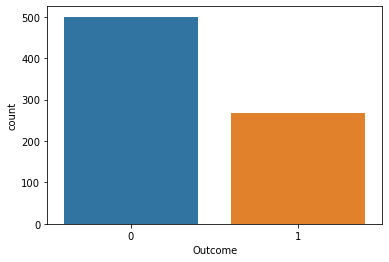

In [21]:
sns.countplot(data["Outcome"])

*The class distribution in the `Target` variable is ~65:35 which is not exactly imbalanced.*

### Feature Selection

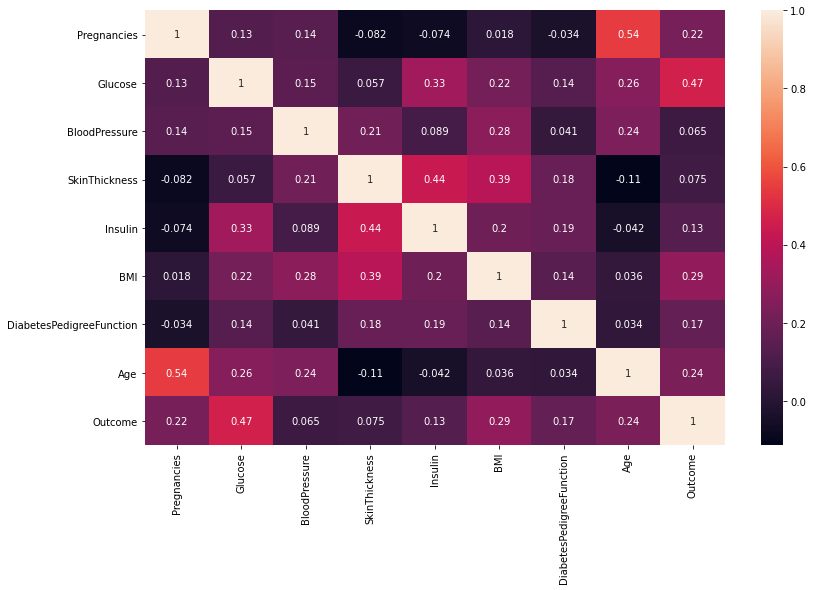

In [22]:
plt.figure(figsize=(13,8))
sns.heatmap(data.corr(), annot=True)

In [23]:
data.describe()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
count,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000
mean,3.845052,120.894531,69.105469,20.536458,79.799479,31.992578,0.471876,33.240885,0.348958
std,3.369578,31.972618,19.355807,15.952218,115.244002,7.884160,0.331329,11.760232,0.476951
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.078000,21.000000,0.000000
25%,1.000000,99.000000,62.000000,0.000000,0.000000,27.300000,0.243750,24.000000,0.000000
50%,3.000000,117.000000,72.000000,23.000000,30.500000,32.000000,0.372500,29.000000,0.000000
75%,6.000000,140.250000,80.000000,32.000000,127.250000,36.600000,0.626250,41.000000,1.000000
max,17.000000,199.000000,122.000000,99.000000,846.000000,67.100000,2.420000,81.000000,1.000000


*As it can be seen that columns `Pregnancies` `Glucose` `BloodPressure` `SkinThickness` `Insulin` `BMI` has 0 values . Therefore these columns need to be imputed with their respective mean value.*

### Separating dependent and independent variables

In [24]:
# feature variables
x= data.iloc[:, :-1]

# target variable
y= data.iloc[:, -1]

### Splitting data into *train* and *test* 

In [25]:
x_train, x_test, y_train, y_test= train_test_split(x,y, test_size=0.2, random_state=1)

### Imputing with mean

In [26]:
from sklearn.impute import SimpleImputer
impute= SimpleImputer(missing_values= 0,  strategy='mean')
x_train= impute.fit_transform(x_train)
x_test= impute.fit_transform(x_test)                              

## Model Building

### Random Forest

In [27]:
rf_classifier= RandomForestClassifier()

rf_params= {"n_estimators" : [int(x) for x in np.linspace( start=100, stop=1000, num=10)],
            "criterion" : ["gini", "entropy"],
            "max_depth" : [int(x) for x in np.linspace(start= 100, stop=1000, num=10)],
            "min_samples_split": [1,3,6,7,8],
            "min_samples_leaf" : [3,4,6,7,9],
            "max_features" : ["auto", "sqrt", "log2"]}

rf_cv= KFold(n_splits=5)

rf_randomSearch= RandomizedSearchCV(estimator= rf_classifier,param_distributions=rf_params, n_iter=100,
                                    scoring="f1_macro", n_jobs=-1, cv= rf_cv, verbose=2, random_state=10)

rf_randomSearch.fit(x_train, y_train)

Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:   14.3s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   52.8s
[Parallel(n_jobs=-1)]: Done 357 tasks      | elapsed:  2.0min
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:  2.7min finished


RandomizedSearchCV(cv=KFold(n_splits=5, random_state=None, shuffle=False),
                   estimator=RandomForestClassifier(), n_iter=100, n_jobs=-1,
                   param_distributions={'criterion': ['gini', 'entropy'],
                                        'max_depth': [100, 200, 300, 400, 500,
                                                      600, 700, 800, 900,
                                                      1000],
                                        'max_features': ['auto', 'sqrt',
                                                         'log2'],
                                        'min_samples_leaf': [3, 4, 6, 7, 9],
                                        'min_samples_split': [1, 3, 6, 7, 8],
                                        'n_estimators': [100, 200, 300, 400,
                                                         500, 600, 700, 800,
                                                         900, 1000]},
                   random_state=10, scori

In [28]:
print(rf_randomSearch.best_score_)
print(rf_randomSearch.best_params_)
print(rf_randomSearch.best_estimator_)

0.7474115999175857
{'n_estimators': 700, 'min_samples_split': 6, 'min_samples_leaf': 4, 'max_features': 'log2', 'max_depth': 1000, 'criterion': 'entropy'}
RandomForestClassifier(criterion='entropy', max_depth=1000, max_features='log2',
                       min_samples_leaf=4, min_samples_split=6,
                       n_estimators=700)


0.8051948051948052
              precision    recall  f1-score   support

           0       0.82      0.90      0.86        99
           1       0.78      0.64      0.70        55

    accuracy                           0.81       154
   macro avg       0.80      0.77      0.78       154
weighted avg       0.80      0.81      0.80       154



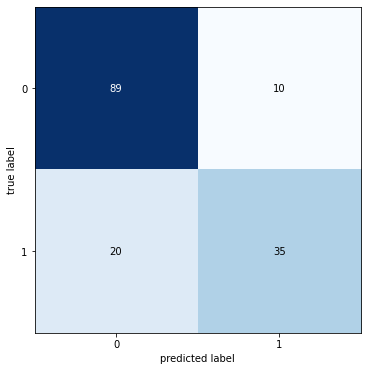

In [30]:
# best model
classifier_rf= rf_randomSearch.best_estimator_

rf_pred= classifier_rf.predict(x_test)

cm= confusion_matrix(y_test, rf_pred)
plot_confusion_matrix(cm, figsize=(6,6))

print(accuracy_score(y_test, rf_pred))
print(classification_report(y_test, rf_pred))

### XgBoost

In [41]:
xgboost_classifier= xgboost.XGBClassifier()

xgboost_params= {"learning_rate": [0.1, 0.2, 0.25, 0.3, 0.35],
                 "max_depth": [3,4,5,7,8,9],
                 "min_child_weight": [2,4,5,6],
                 "gamma": [0.1, 0.2, 0.3, 0.4],
                 "colsample_bytree": [0.2,0.3, 0.4, 0.5]}

xgboost_cv= KFold(n_splits=5)

xgboost_search= RandomizedSearchCV(estimator= xgboost_classifier, param_distributions=xgboost_params, n_iter=100,
                                   scoring= "roc_auc", n_jobs=-1, cv=xgboost_cv, verbose=2, random_state=1)


xgboost_search.fit(x_train, y_train)

print(xgboost_search.best_score_)
print(xgboost_search.best_params_)
print(xgboost_search.best_estimator_)

Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  92 tasks      | elapsed:    1.2s


0.8228860777857833
{'min_child_weight': 2, 'max_depth': 3, 'learning_rate': 0.1, 'gamma': 0.1, 'colsample_bytree': 0.5}
XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.5, gamma=0.1, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=2, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=0, num_parallel_tree=1, random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)


[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:    6.2s finished


0.7857142857142857
              precision    recall  f1-score   support

           0       0.81      0.87      0.84        99
           1       0.73      0.64      0.68        55

    accuracy                           0.79       154
   macro avg       0.77      0.75      0.76       154
weighted avg       0.78      0.79      0.78       154



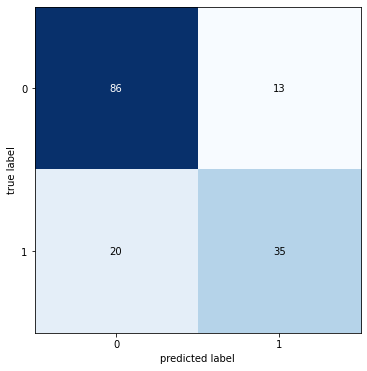

In [42]:
classifier_xgboost= xgboost_search.best_estimator_

xgboost_pred= classifier_xgboost.predict(x_test)

cm2= confusion_matrix(y_test, xgboost_pred)
plot_confusion_matrix(cm2, figsize=(6,6))

print(accuracy_score(y_test, xgboost_pred))
print(classification_report(y_test, xgboost_pred))

### Creating pickle file

In [47]:
pickle_out= open("classifier_diabetes.pkl", "wb")

pickle.dump(classifier_xgboost, pickle_out)
pickle_out.close()